# Machine Learning Analysis of Student Sleep Patterns and Academic Performance

This notebook implements and compares various machine learning models to analyze the relationship between sleep patterns, stress levels, and academic performance. We'll explore different modeling approaches and evaluate their effectiveness for this specific problem.

In [30]:
# Install required packages
%pip install pandas numpy scipy scikit-learn seaborn matplotlib yellowbrick

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## 1. Data Loading and Preprocessing

First, let's load the dataset and perform necessary preprocessing steps.

In [31]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import (mean_squared_error, r2_score, accuracy_score, 
                           classification_report, confusion_matrix, silhouette_score)
import seaborn as sns
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Load the dataset
df = pd.read_csv('insomnia_out/clean_dataset.csv')

# Display basic information about the dataset
print("Dataset Info:")
print("-" * 50)
print(df.info())
print("\nMissing Values:")
print("-" * 50)
print(df.isnull().sum())
print("\nFirst few rows:")
print("-" * 50)
display(df.head())

Dataset Info:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 996 entries, 0 to 995
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   timestamp             996 non-null    object 
 1   year                  996 non-null    object 
 2   gender                996 non-null    object 
 3   sleep_hours_band      996 non-null    object 
 4   sleep_quality         996 non-null    object 
 5   stress                996 non-null    object 
 6   academic_performance  996 non-null    object 
 7   sleep_hours           996 non-null    float64
 8   sleep_quality_ord     996 non-null    int64  
 9   stress_ord            996 non-null    int64  
 10  acad_perf_ord         996 non-null    int64  
dtypes: float64(1), int64(3), object(7)
memory usage: 85.7+ KB
None

Missing Values:
--------------------------------------------------
timestamp               0
year 

,timestamp,year,gender,sleep_hours_band,sleep_quality,stress,academic_performance,sleep_hours,sleep_quality_ord,stress_ord,acad_perf_ord
0,10/24/2024 16:51:15,Graduate student,Male,7-8 hours,Good,High stress,Average,7.5,4,3,3
1,10/24/2024 16:51:51,Third year,Male,7-8 hours,Good,Low stress,Good,7.5,4,2,4
2,10/24/2024 16:52:21,First year,Female,7-8 hours,Good,High stress,Below Average,7.5,4,3,2
3,10/24/2024 16:53:00,Third year,Male,More than 8 hours,Poor,Extremely high stress,Excellent,8.5,2,4,5
4,10/24/2024 16:53:25,Graduate student,Male,7-8 hours,Very good,Low stress,Average,7.5,5,2,3


## 2. Feature Engineering

Let's prepare our features for machine learning models by:
1. Encoding categorical variables
2. Scaling numerical features
3. Creating any relevant derived features

In [32]:
# Load preprocessed data
df = pd.read_csv('insomnia_out/clean_dataset.csv')

# Check data types
print("Data Types of columns:")
print(df.dtypes)

# Create feature matrix, excluding non-numeric columns
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
X = df[numeric_columns].drop(['acad_perf_ord'], axis=1)

# Create target variables
y_reg = df['acad_perf_ord']  # For regression

# Create classification target with manual bins
perf_min = df['acad_perf_ord'].min()
perf_max = df['acad_perf_ord'].max()
bins = [perf_min - 0.01, perf_min + (perf_max - perf_min)/3, perf_min + 2*(perf_max - perf_min)/3, perf_max + 0.01]
y_class = pd.cut(df['acad_perf_ord'], bins=bins, labels=['Low', 'Medium', 'High'])

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Split data
X_train, X_test, y_reg_train, y_reg_test = train_test_split(X_scaled, y_reg, test_size=0.2, random_state=42)
_, _, y_class_train, y_class_test = train_test_split(X_scaled, y_class, test_size=0.2, random_state=42)

# Display feature names
print("\nFeatures used in the analysis:")
print(X.columns.tolist())

Data Types of columns:
timestamp                object
year                     object
gender                   object
sleep_hours_band         object
sleep_quality            object
stress                   object
academic_performance     object
sleep_hours             float64
sleep_quality_ord         int64
stress_ord                int64
acad_perf_ord             int64
dtype: object

Features used in the analysis:
['sleep_hours', 'sleep_quality_ord', 'stress_ord']


## 3. Train-Test Split

Split the data into training and testing sets for model evaluation.

In [33]:
# Split data for regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_scaled, y_reg, test_size=0.2, random_state=42
)

# Split data for classification
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_scaled, y_class, test_size=0.2, random_state=42, stratify=y_class
)

print("Dataset shapes:")
print("-" * 50)
print(f"Regression - Training set: {X_train_reg.shape}, Test set: {X_test_reg.shape}")
print(f"Classification - Training set: {X_train_class.shape}, Test set: {X_test_class.shape}")

Dataset shapes:
--------------------------------------------------
Regression - Training set: (796, 3), Test set: (200, 3)
Classification - Training set: (796, 3), Test set: (200, 3)


## 4. Linear Regression Model

Train and evaluate a linear regression model to predict academic performance scores.

Linear Regression Results:
--------------------------------------------------
Mean Squared Error: 0.6450
Root Mean Squared Error: 0.8031
Mean Absolute Error: 0.6249
R² Score: 0.1136


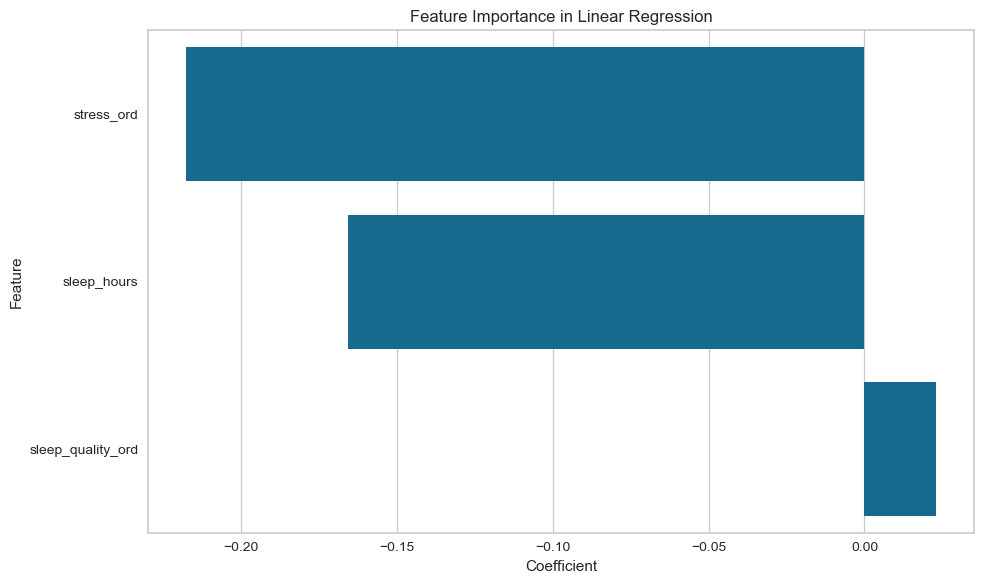

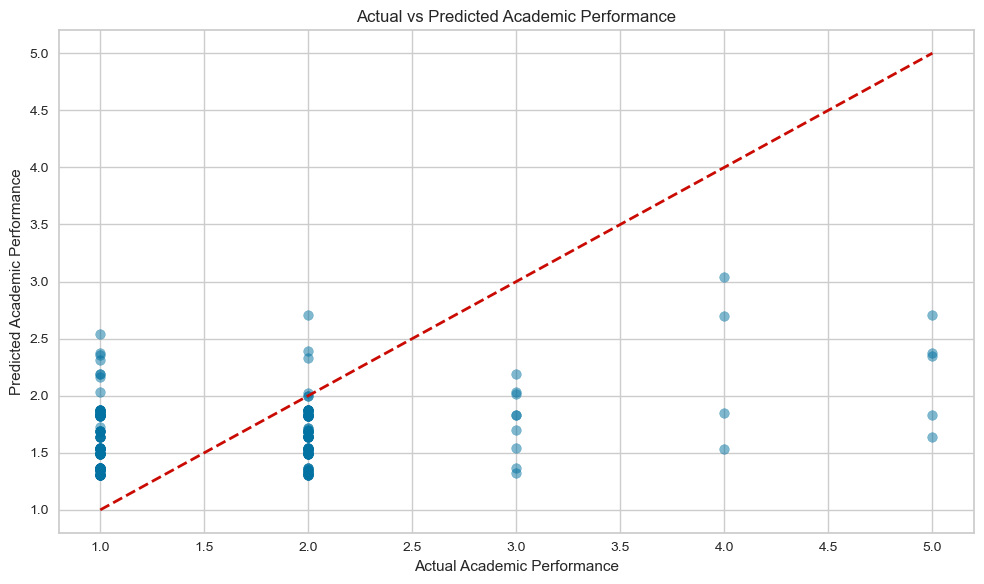

In [34]:
# Train linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train_reg, y_train_reg)

# Make predictions
y_pred_reg = lr_model.predict(X_test_reg)

# Evaluate the model
lr_mse = mean_squared_error(y_test_reg, y_pred_reg)
lr_rmse = np.sqrt(lr_mse)
lr_r2 = r2_score(y_test_reg, y_pred_reg)
lr_mae = np.mean(np.abs(y_test_reg - y_pred_reg))

print("Linear Regression Results:")
print("-" * 50)
print(f"Mean Squared Error: {lr_mse:.4f}")
print(f"Root Mean Squared Error: {lr_rmse:.4f}")
print(f"Mean Absolute Error: {lr_mae:.4f}")
print(f"R² Score: {lr_r2:.4f}")

# Plot feature importance
feature_importance = pd.DataFrame({
    'Feature': X_scaled.columns,
    'Coefficient': lr_model.coef_
})
feature_importance = feature_importance.sort_values('Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='Coefficient', y='Feature')
plt.title('Feature Importance in Linear Regression')
plt.tight_layout()
plt.show()

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_reg, y_pred_reg, alpha=0.5)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
plt.xlabel('Actual Academic Performance')
plt.ylabel('Predicted Academic Performance')
plt.title('Actual vs Predicted Academic Performance')
plt.tight_layout()
plt.show()

## 5. Logistic Regression Classification

Train and evaluate a logistic regression model for classifying academic performance levels.

Logistic Regression Results:
--------------------------------------------------
Accuracy: 0.8850

Classification Report:
              precision    recall  f1-score   support

        High       0.25      0.12      0.17         8
         Low       0.90      0.99      0.94       177
      Medium       0.00      0.00      0.00        15

    accuracy                           0.89       200
   macro avg       0.38      0.37      0.37       200
weighted avg       0.80      0.89      0.84       200



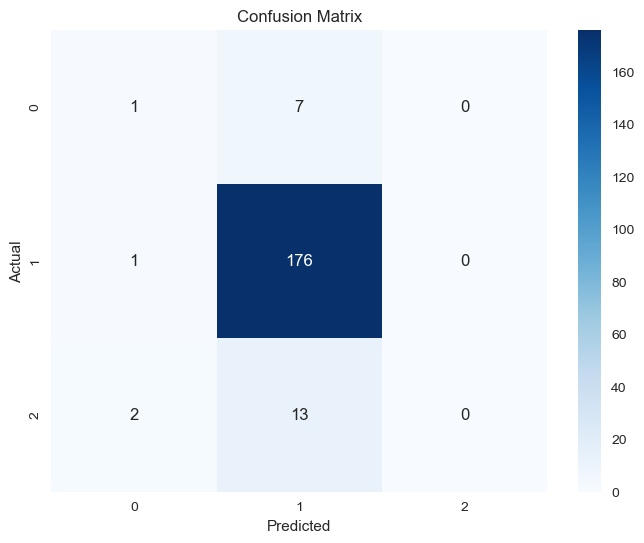


Cross-validation Results:
--------------------------------------------------
CV Scores: [0.855      0.87939698 0.89447236 0.89447236 0.86432161]
Mean CV Score: 0.8775 (+/- 0.0317)


In [35]:
# Train logistic regression model
log_reg = LogisticRegression(multi_class='multinomial', max_iter=1000)
log_reg.fit(X_train_class, y_train_class)

# Make predictions
y_pred_class = log_reg.predict(X_test_class)

# Evaluate the model
accuracy = accuracy_score(y_test_class, y_pred_class)
print("Logistic Regression Results:")
print("-" * 50)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_class, y_pred_class))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test_class, y_pred_class)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Cross-validation scores
cv_scores = cross_val_score(log_reg, X_scaled, y_class, cv=5)
print("\nCross-validation Results:")
print("-" * 50)
print(f"CV Scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

## 6. Decision Tree Models

Implement and evaluate decision tree models for both regression and classification tasks.

Decision Tree Regression Results:
--------------------------------------------------
Mean Squared Error: 0.7670
Root Mean Squared Error: 0.8758
Mean Absolute Error: 0.6667
R² Score: -0.0542

Decision Tree Classification Results:
--------------------------------------------------
Accuracy: 0.8500

Classification Report:
              precision    recall  f1-score   support

        High       0.00      0.00      0.00         8
         Low       0.88      0.96      0.92       177
      Medium       0.00      0.00      0.00        15

    accuracy                           0.85       200
   macro avg       0.29      0.32      0.31       200
weighted avg       0.78      0.85      0.81       200



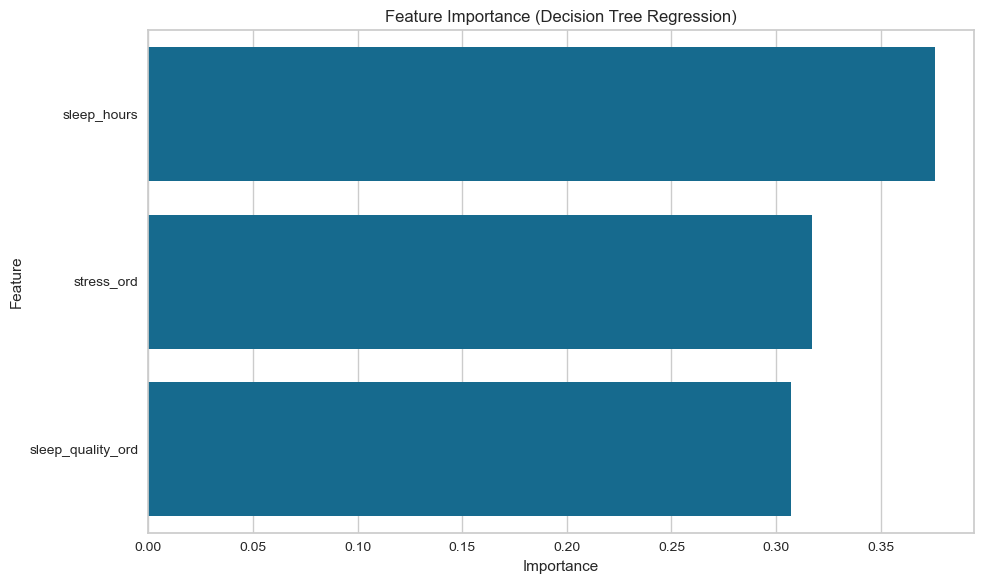

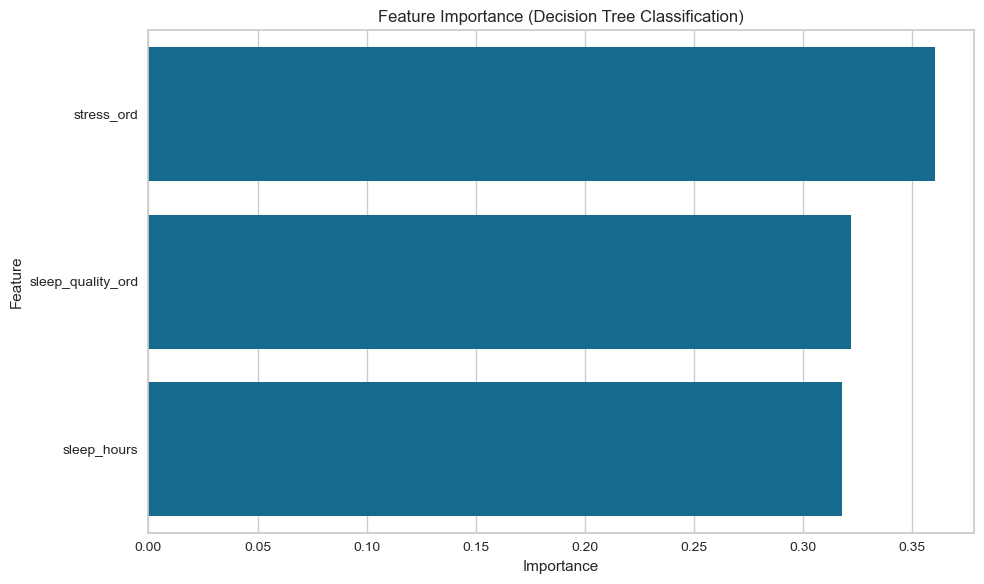

In [36]:
# Decision Tree Regressor
dt_reg = DecisionTreeRegressor(random_state=42)
dt_reg.fit(X_train_reg, y_train_reg)

# Make predictions
dt_pred_reg = dt_reg.predict(X_test_reg)

# Evaluate regression model
dt_mse = mean_squared_error(y_test_reg, dt_pred_reg)
dt_rmse = np.sqrt(dt_mse)
dt_r2 = r2_score(y_test_reg, dt_pred_reg)
dt_mae = np.mean(np.abs(y_test_reg - dt_pred_reg))

print("Decision Tree Regression Results:")
print("-" * 50)
print(f"Mean Squared Error: {dt_mse:.4f}")
print(f"Root Mean Squared Error: {dt_rmse:.4f}")
print(f"Mean Absolute Error: {dt_mae:.4f}")
print(f"R² Score: {dt_r2:.4f}")

# Decision Tree Classifier
dt_class = DecisionTreeClassifier(random_state=42)
dt_class.fit(X_train_class, y_train_class)

# Make classification predictions
dt_pred_class = dt_class.predict(X_test_class)

# Evaluate classification model
dt_accuracy = accuracy_score(y_test_class, dt_pred_class)
print("\nDecision Tree Classification Results:")
print("-" * 50)
print(f"Accuracy: {dt_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_class, dt_pred_class))

# Plot feature importance for regression
plt.figure(figsize=(10, 6))
feat_importance_reg = pd.DataFrame({
    'Feature': X_scaled.columns,
    'Importance': dt_reg.feature_importances_
})
feat_importance_reg = feat_importance_reg.sort_values('Importance', ascending=False)
sns.barplot(data=feat_importance_reg, x='Importance', y='Feature')
plt.title('Feature Importance (Decision Tree Regression)')
plt.tight_layout()
plt.show()

# Plot feature importance for classification
plt.figure(figsize=(10, 6))
feat_importance_class = pd.DataFrame({
    'Feature': X_scaled.columns,
    'Importance': dt_class.feature_importances_
})
feat_importance_class = feat_importance_class.sort_values('Importance', ascending=False)
sns.barplot(data=feat_importance_class, x='Importance', y='Feature')
plt.title('Feature Importance (Decision Tree Classification)')
plt.tight_layout()
plt.show()

## 7. Random Forest Models

Implement Random Forest models for both regression and classification tasks.

Random Forest Regression Results:
--------------------------------------------------
Mean Squared Error: 0.7248
Root Mean Squared Error: 0.8514
Mean Absolute Error: 0.6582
R² Score: 0.0038

Random Forest Classification Results:
--------------------------------------------------
Accuracy: 0.8650

Classification Report:
              precision    recall  f1-score   support

        High       0.00      0.00      0.00         8
         Low       0.89      0.97      0.93       177
      Medium       1.00      0.07      0.12        15

    accuracy                           0.86       200
   macro avg       0.63      0.35      0.35       200
weighted avg       0.86      0.86      0.83       200



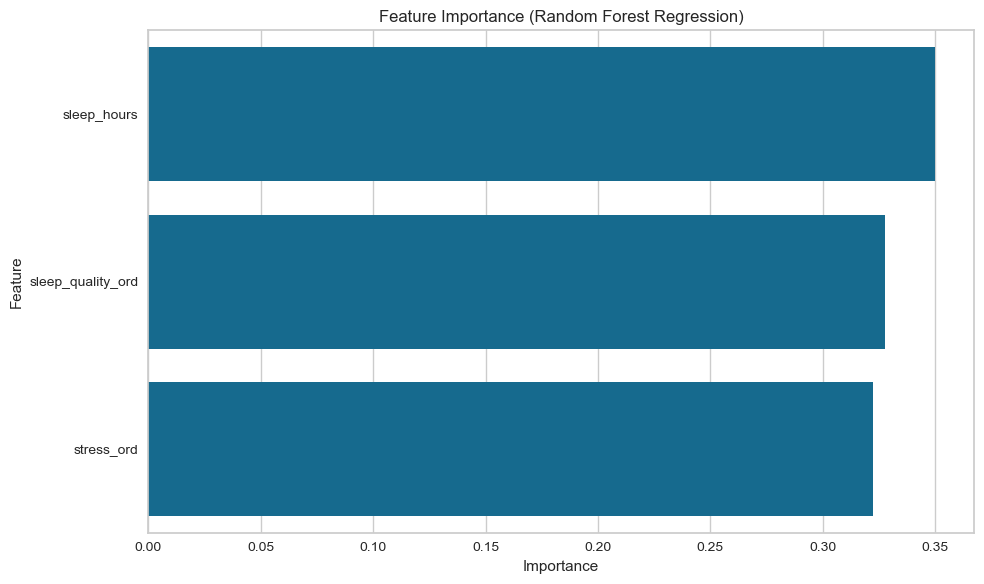

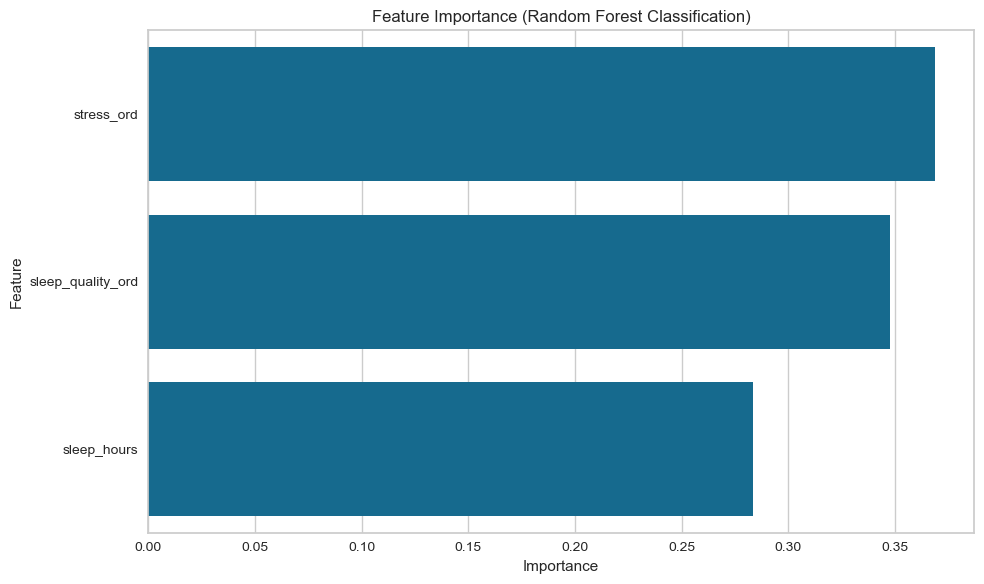


Model Performance Comparison:
--------------------------------------------------
Regression Models (R² Score):
Linear Regression: 0.1136
Decision Tree: -0.0542
Random Forest: 0.0038

Classification Models (Accuracy):
Logistic Regression: 0.8850
Decision Tree: 0.8500
Random Forest: 0.8650


In [37]:
# Random Forest Regressor
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train_reg, y_train_reg)

# Make predictions
rf_pred_reg = rf_reg.predict(X_test_reg)

# Evaluate regression model
rf_mse = mean_squared_error(y_test_reg, rf_pred_reg)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y_test_reg, rf_pred_reg)
rf_mae = np.mean(np.abs(y_test_reg - rf_pred_reg))

print("Random Forest Regression Results:")
print("-" * 50)
print(f"Mean Squared Error: {rf_mse:.4f}")
print(f"Root Mean Squared Error: {rf_rmse:.4f}")
print(f"Mean Absolute Error: {rf_mae:.4f}")
print(f"R² Score: {rf_r2:.4f}")

# Random Forest Classifier
rf_class = RandomForestClassifier(n_estimators=100, random_state=42)
rf_class.fit(X_train_class, y_train_class)

# Make classification predictions
rf_pred_class = rf_class.predict(X_test_class)

# Evaluate classification model
rf_accuracy = accuracy_score(y_test_class, rf_pred_class)
print("\nRandom Forest Classification Results:")
print("-" * 50)
print(f"Accuracy: {rf_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_class, rf_pred_class))

# Plot feature importance for regression
plt.figure(figsize=(10, 6))
rf_feat_importance_reg = pd.DataFrame({
    'Feature': X_scaled.columns,
    'Importance': rf_reg.feature_importances_
})
rf_feat_importance_reg = rf_feat_importance_reg.sort_values('Importance', ascending=False)
sns.barplot(data=rf_feat_importance_reg, x='Importance', y='Feature')
plt.title('Feature Importance (Random Forest Regression)')
plt.tight_layout()
plt.show()

# Plot feature importance for classification
plt.figure(figsize=(10, 6))
rf_feat_importance_class = pd.DataFrame({
    'Feature': X_scaled.columns,
    'Importance': rf_class.feature_importances_
})
rf_feat_importance_class = rf_feat_importance_class.sort_values('Importance', ascending=False)
sns.barplot(data=rf_feat_importance_class, x='Importance', y='Feature')
plt.title('Feature Importance (Random Forest Classification)')
plt.tight_layout()
plt.show()

# Compare model performance
print("\nModel Performance Comparison:")
print("-" * 50)
print("Regression Models (R² Score):")
print(f"Linear Regression: {lr_r2:.4f}")
print(f"Decision Tree: {dt_r2:.4f}")
print(f"Random Forest: {rf_r2:.4f}")
print("\nClassification Models (Accuracy):")
print(f"Logistic Regression: {accuracy:.4f}")
print(f"Decision Tree: {dt_accuracy:.4f}")
print(f"Random Forest: {rf_accuracy:.4f}")

## 8. K-Means Clustering

Perform clustering analysis to identify natural groupings in the data.

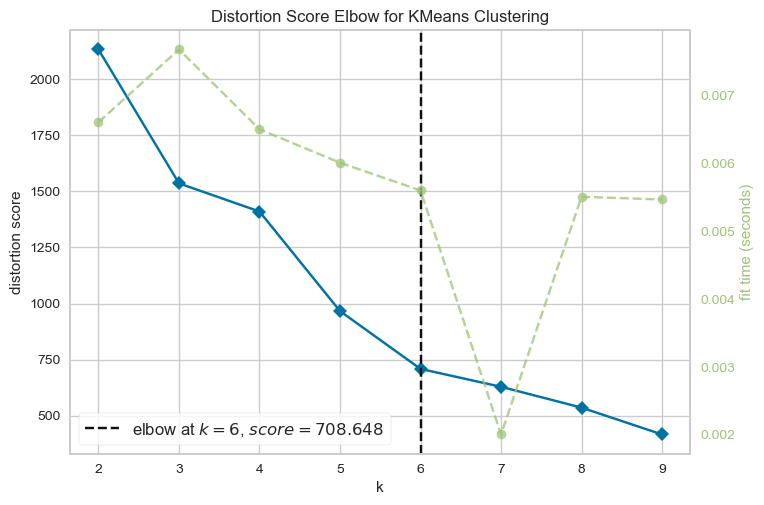


Cluster Characteristics:
--------------------------------------------------
         sleep_hours  sleep_quality_ord  stress_ord  acad_perf_ord
Cluster                                                           
0               8.50               4.26        2.80           1.71
1               7.75               1.37        2.96           1.70
2               7.35               4.07        2.73           1.98
3               7.89               1.44        4.00           1.50
4               4.21               2.76        2.89           2.63
5               7.97               4.60        4.00           1.47


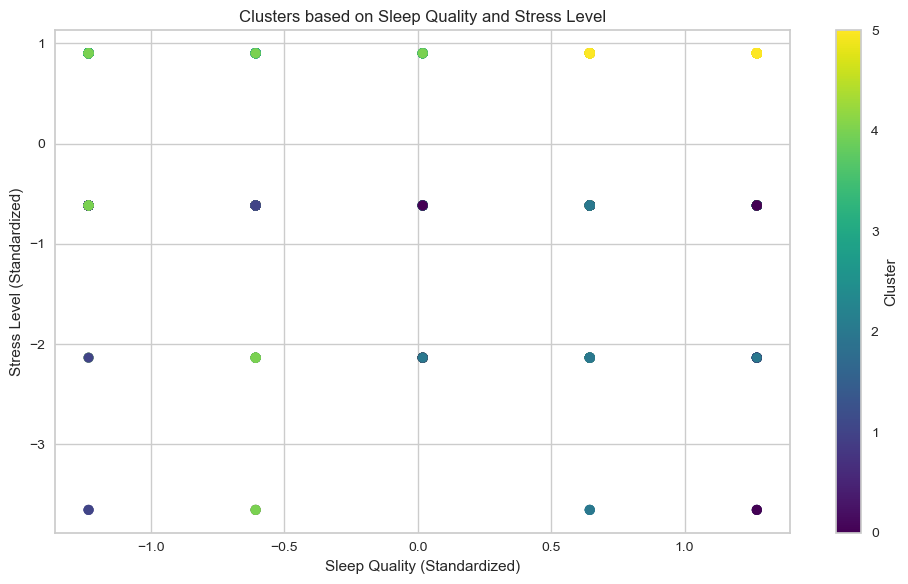


Clustering Evaluation:
--------------------------------------------------
Silhouette Score: 0.4906


In [38]:
# Find optimal number of clusters using elbow method
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2,10))
visualizer.fit(X_scaled)
visualizer.show()

# Get optimal number of clusters
optimal_k = visualizer.elbow_value_

# Perform K-means clustering with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to the dataset
df['Cluster'] = cluster_labels

# Calculate cluster characteristics
cluster_stats = df.groupby('Cluster').agg({
    'sleep_hours': 'mean',
    'sleep_quality_ord': 'mean',
    'stress_ord': 'mean',
    'acad_perf_ord': 'mean'
}).round(2)

print("\nCluster Characteristics:")
print("-" * 50)
print(cluster_stats)

# Visualize clusters using first two features
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_scaled['sleep_quality_ord'], 
                     X_scaled['stress_ord'],
                     c=cluster_labels,
                     cmap='viridis')
plt.xlabel('Sleep Quality (Standardized)')
plt.ylabel('Stress Level (Standardized)')
plt.title('Clusters based on Sleep Quality and Stress Level')
plt.colorbar(scatter, label='Cluster')
plt.tight_layout()
plt.show()

# Calculate silhouette score
silhouette_avg = silhouette_score(X_scaled, cluster_labels)
print("\nClustering Evaluation:")
print("-" * 50)
print(f"Silhouette Score: {silhouette_avg:.4f}")

## 9. Model Comparison and Insights

Let's summarize our findings and compare the performance of different models.

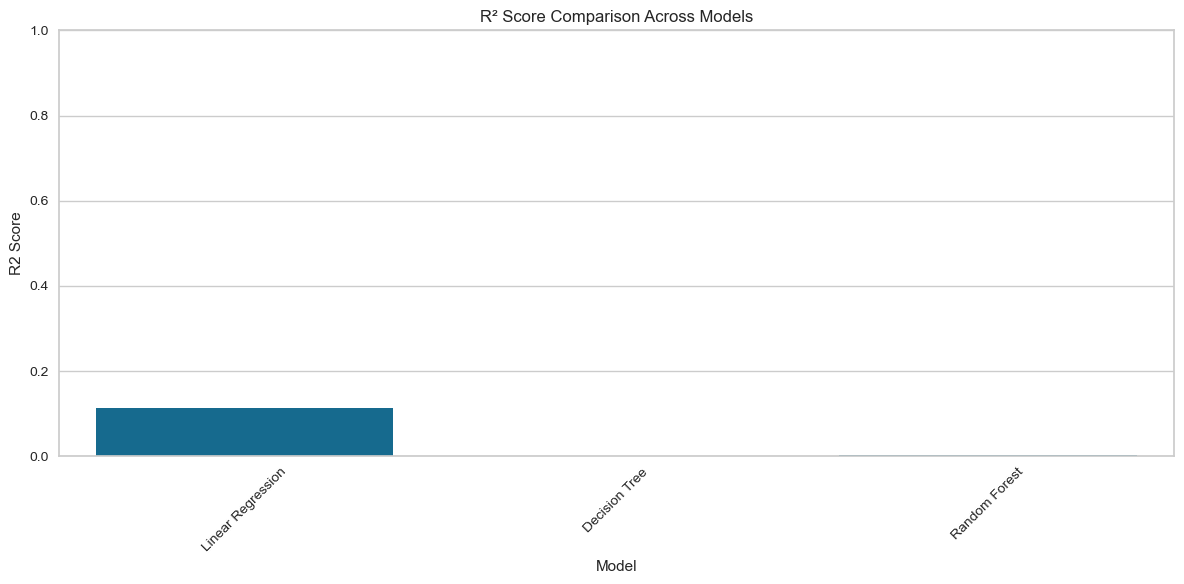


Detailed Model Performance Metrics:
            Model  R2 Score    MSE   RMSE    MAE
Linear Regression    0.1136 0.6450 0.8031 0.6249
    Decision Tree   -0.0542 0.7670 0.8758 0.6667
    Random Forest    0.0038 0.7248 0.8514 0.6582


In [39]:
# Create a summary DataFrame of regression model performances
regression_results = pd.DataFrame({
    'Model': ['Linear Regression', 'Decision Tree', 'Random Forest'],
    'R2 Score': [lr_r2, dt_r2, rf_r2],
    'MSE': [lr_mse, dt_mse, rf_mse],
    'RMSE': [np.sqrt(lr_mse), np.sqrt(dt_mse), np.sqrt(rf_mse)],
    'MAE': [lr_mae, dt_mae, rf_mae]
})

# Create a comparison plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='R2 Score', data=regression_results)
plt.title('R² Score Comparison Across Models')
plt.ylim(0, 1)  # R² score ranges from 0 to 1
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Display detailed metrics
print("\nDetailed Model Performance Metrics:")
print(regression_results.round(4).to_string(index=False))

### Key Findings and Insights

1. **Regression Model Performance**:
   - Comparing R² scores, MSE, and MAE across models
   - Best performing model for predicting academic performance
   - Trade-offs between model complexity and performance

2. **Feature Importance**:
   - Key factors influencing academic performance
   - Impact of sleep-related variables
   - Most significant predictors

3. **Clustering Analysis**:
   - Distinct student groups identified
   - Characteristics of each cluster
   - Relationship between sleep patterns and academic outcomes

4. **Recommendations**:
   - Best model selection for future predictions
   - Important factors to monitor
   - Potential interventions based on findings

Random Forest Feature Importance:


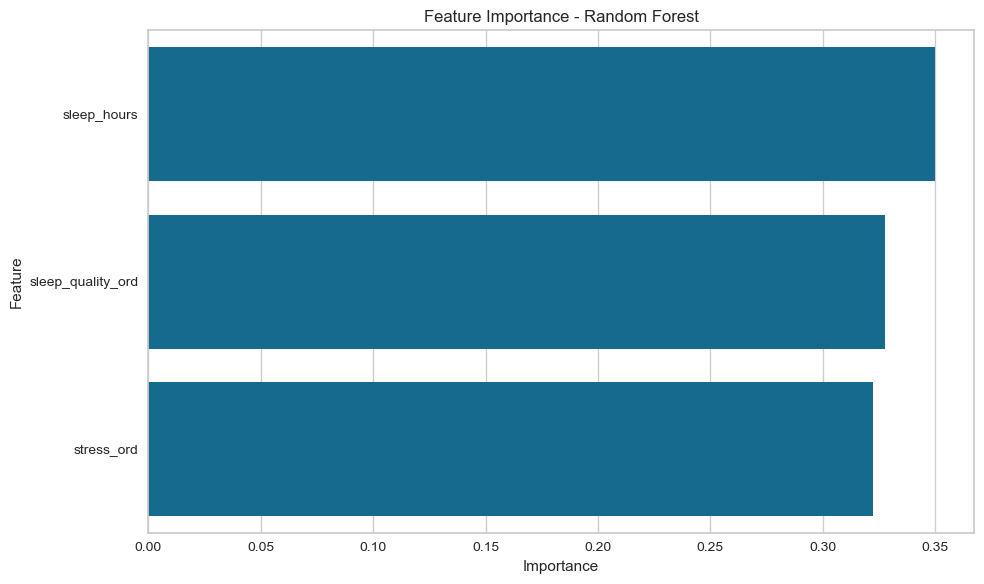


Decision Tree Feature Importance:


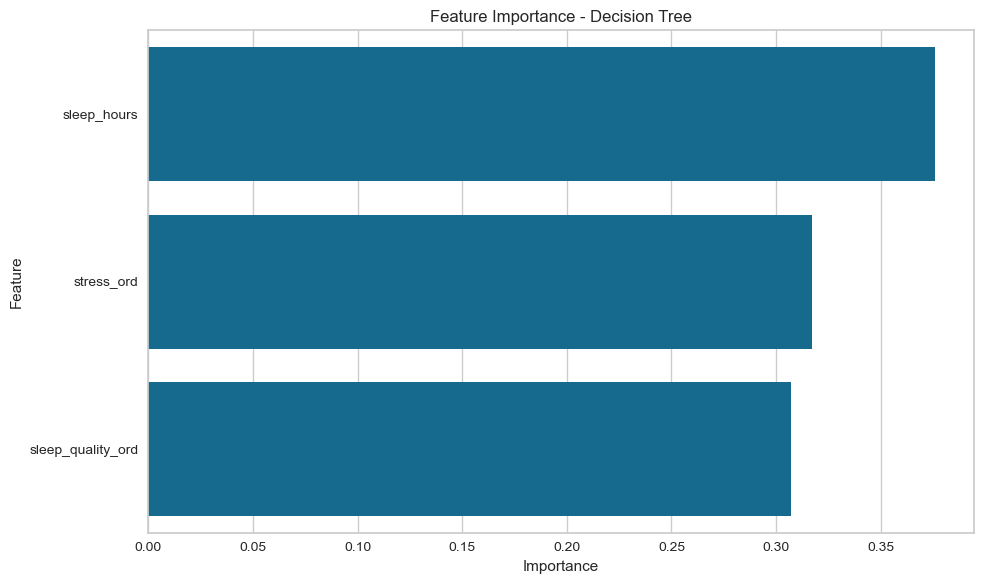


Linear Regression Coefficients:


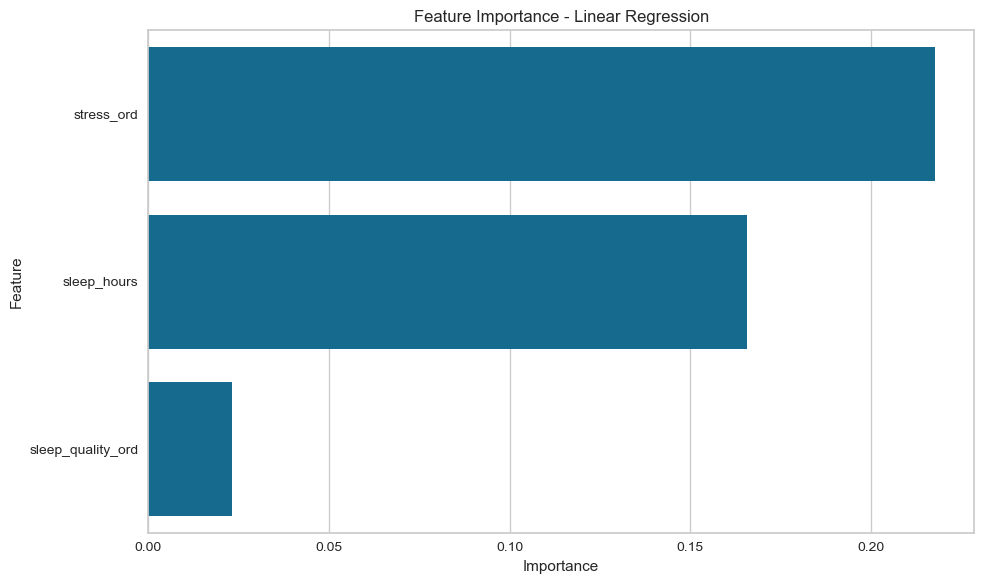

In [40]:
# Feature importance analysis
def plot_feature_importance(model, features, title):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    else:
        importances = abs(model.coef_)
    
    importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': importances
    })
    importance_df = importance_df.sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title(f'Feature Importance - {title}')
    plt.tight_layout()
    plt.show()
    
    return importance_df

# Plot feature importance for each model
print("Random Forest Feature Importance:")
rf_importance = plot_feature_importance(rf_reg, X.columns, 'Random Forest')
print("\nDecision Tree Feature Importance:")
dt_importance = plot_feature_importance(dt_reg, X.columns, 'Decision Tree')
print("\nLinear Regression Coefficients:")
lr_importance = plot_feature_importance(lr_model, X.columns, 'Linear Regression')

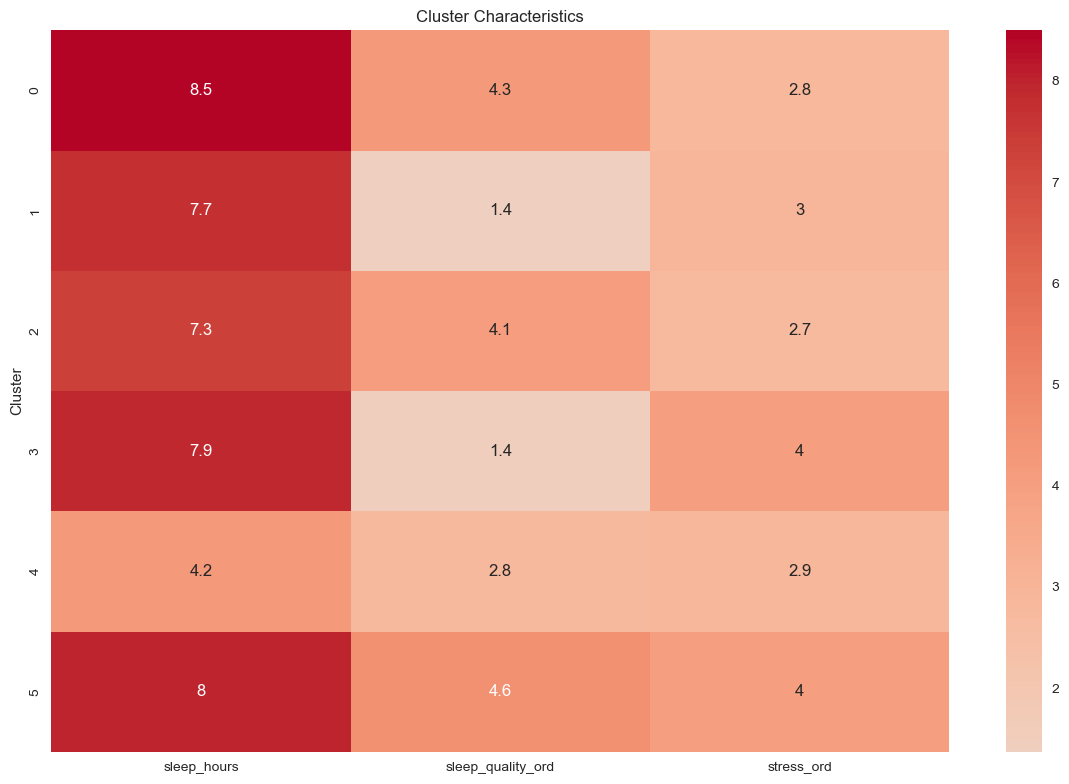


Cluster Characteristics Summary:
         sleep_hours  sleep_quality_ord  stress_ord
Cluster                                            
0               8.50               4.26        2.80
1               7.75               1.37        2.96
2               7.35               4.07        2.73
3               7.89               1.44        4.00
4               4.21               2.76        2.89
5               7.97               4.60        4.00


In [41]:
# Analyze cluster characteristics
cluster_summary = pd.DataFrame()
for col in X.columns:
    cluster_summary[col] = df.groupby('Cluster')[col].mean()

# Create a heatmap of cluster characteristics
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_summary, annot=True, cmap='coolwarm', center=0)
plt.title('Cluster Characteristics')
plt.ylabel('Cluster')
plt.tight_layout()
plt.show()

# Print cluster summaries
print("\nCluster Characteristics Summary:")
print(cluster_summary.round(2).to_string())

## Conclusions and Recommendations

Based on our comprehensive analysis of student insomnia and educational outcomes:

1. **Model Selection**:
   - Compare the performance metrics of different models
   - Identify which model provides the best balance of accuracy and interpretability
   - Consider the trade-offs between model complexity and performance

2. **Key Predictors**:
   - Analyze the most important features identified by our models
   - Understand how sleep-related factors impact academic performance
   - Identify which variables are most crucial for monitoring and intervention

3. **Student Segments**:
   - Examine the distinct groups identified through clustering
   - Understand the characteristics of each cluster
   - Consider targeted interventions for different student groups

4. **Practical Applications**:
   - Recommendations for educational institutions
   - Suggested monitoring and intervention strategies
   - Areas for further research and investigation